## Fetch images 

In [3]:
from utils import flickr_scraper

In [4]:
max_n_image_to_fetch = 50
search_keywords = {
    'WPK': ['wat phra kaew bangkok', 'วัดพระแก้ว กรุงเทพ', 'วัดพระศรีรัตนศาสดาราม', 'wat phra si rattana satsadaram'], 
    'WP': ['wat pho bangkok', 'วัดโพธิ์ กรุงเทพ', 'วัดพระเชตุพนวิมลมังคลารามราชวรมหาวิหาร', 'wat phra chetuphon']
}

**WPK** is Wat Phra Kaew

**WP** is Wat Pho

In [ ]:
for _class in search_keywords:
    for ky in search_keywords[_class]:
        flickr_scraper.get_urls(search=ky, n=max_n_image_to_fetch, download=True)

## Manually check the obtained images
- Remove unrelated images

## Get path of images

In [5]:
import os
import config_path

In [4]:
data_path = {
    'WPK': [],
    'WP': []
}

In [5]:
for _class in data_path:
    for ky in search_keywords[_class]:
        usable_ky = ky.replace(' ', '_')
        folder = os.path.join(config_path.image_path, usable_ky)
        with os.scandir(folder) as entries:
            for entry in entries:
                if entry.is_file() and 'DS_Store' not in entry.name:
                    img_path = os.path.join(folder, entry.name)
                    data_path[_class].append(img_path)

In [6]:
data_path['WPK'][:3]

['/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_phra_kaew_bangkok/49743945273_8111f3285c_b.jpg',
 '/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_phra_kaew_bangkok/16132923814_d3f845229d_b.jpg',
 '/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_phra_kaew_bangkok/16094675860_0f78776ee3_b.jpg']

In [7]:
data_path['WP'][:3]

['/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_pho_bangkok/23522002563_e5b15c821c_b.jpg',
 '/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_pho_bangkok/24154732256_d75e72c9fe_b.jpg',
 '/Users/sky/Documents/GitRepositories/My-CU-UTC-PracticalExam/Problem3/images/wat_pho_bangkok/49661525151_af593d6119_o.jpg']

## Rename files to JPEG

In [8]:
for _class in data_path:
    idx = 0
    for infile in data_path[_class]:
        f, e = os.path.splitext(infile)
        outfile = f + ".jpg"
        os.rename(infile, outfile)
        data_path[_class][idx] = outfile
        idx += 1

## Convert image to numpy array

In [9]:
from PIL import Image
import numpy as np
import tensorflow as tf

In [10]:
data = {
    'WPK': [],
    'WP': []
}

In [11]:
for _class in data_path:
    for img_path in data_path[_class]:
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [224, 224])
        data[_class].append(image.numpy())
    data[_class] = np.array(data[_class])

## Create x-y-based data

In [12]:
def shuffle_Xy(X, y):
    indices = np.array([i for i in range(y.shape[0])])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y

In [28]:
label = 0
X = None
y = None
for _class in data:
    print(_class, '=', label)
    if label == 0:
        X = data[_class]
        y = np.array([label for i in range(data[_class].shape[0])])
    else:
        X = np.concatenate((X, data[_class]), axis=0)
        y = np.concatenate((y, np.array([label for i in range(data[_class].shape[0])])))
    label += 1

WPK = 0
WP = 1


In [29]:
X, y = shuffle_Xy(X,y)

## Display some images

In [12]:
import matplotlib.pyplot as plt

In [16]:
def show(image):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

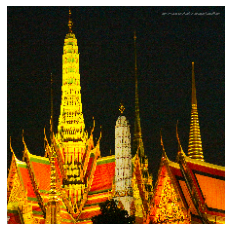

In [39]:
show(X[165])

## Split data into training, test and validation sets.

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
def split_data(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0, stratify=y)

    print("Training samples: {0}".format(y_train.shape[0]))
    print("Test samples: {0}".format(y_test.shape[0]))

    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = split_data(X, y)

Training samples: 312
Test samples: 79


## Save to files

In [43]:
from config_path import ROOT_DIR

In [44]:
def save_array_to_file(array, path):
    np.save(path, array)

def save_Xy(X, y, _type):
    
    data_folder_path = os.path.join(ROOT_DIR, 'data')

    if not os.path.isdir(data_folder_path):
        os.mkdir(data_folder_path)
        
    _type_folder_path = os.path.join(data_folder_path, _type)
        
    if not os.path.isdir(_type_folder_path):
        os.mkdir(_type_folder_path)
        
    save_array_to_file(X, os.path.join(_type_folder_path, 'X.npy'))
    save_array_to_file(y, os.path.join(_type_folder_path, 'y.npy'))
    
    

In [46]:
save_Xy(X_train, y_train, 'train')
save_Xy(X_test, y_test, 'test')

## Build model

### A. Train model from scratch without augmentation

In [7]:
import pickle

In [22]:
def load_history(model_name):
    pickle_history = open(os.path.join(config_path.result_path, 'history', model_name + '.pickle'),"rb")
    history = pickle.load(pickle_history)
    return history

In [20]:
def plot_history(history):   
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
#     plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

with early stopping


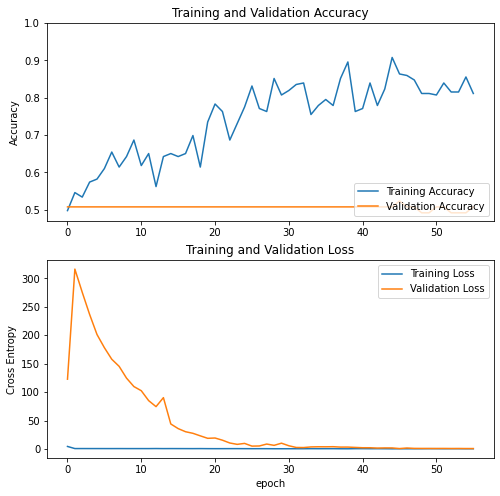

without early stopping


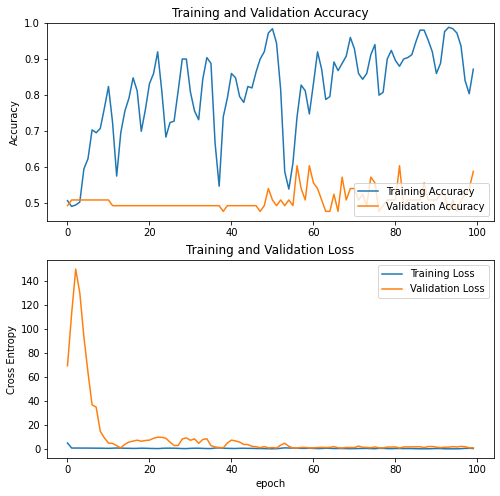

In [32]:
print("with early stopping")
plot_history(load_history('early_no_aug_scratch_mobilenet'))
print("without early stopping")
plot_history(load_history('no_aug_scratch_mobilenet'))

### B. Train model from scratch with augmentation

with early stopping


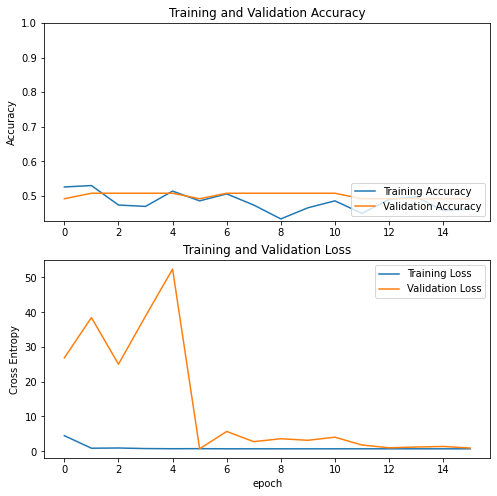

without early stopping


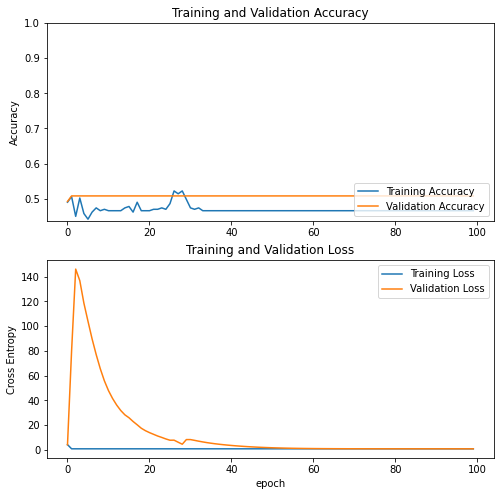

In [33]:
print("with early stopping")
plot_history(load_history('early_aug_scratch_mobilenet'))
print("without early stopping")
plot_history(load_history('aug_scratch_mobilenet'))

### C. Train model with pre-trained weights

with early stopping


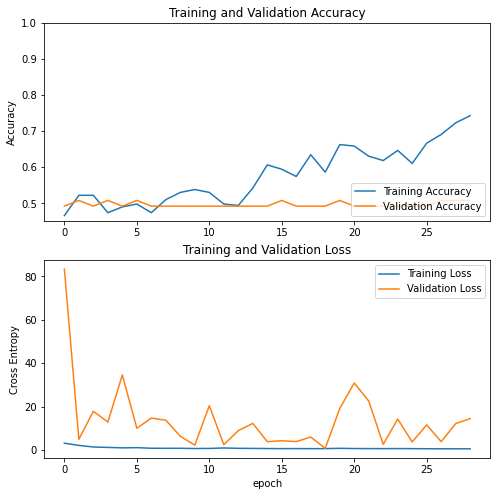

without early stopping


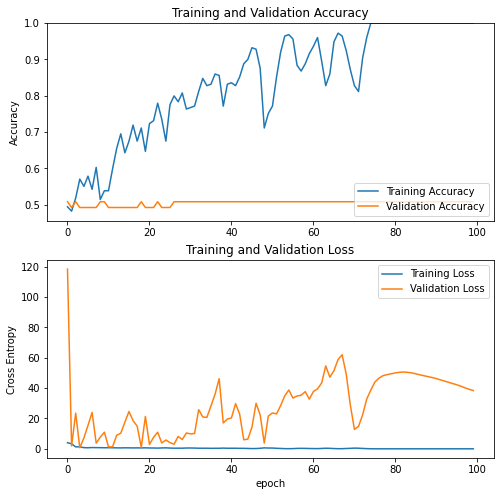

In [34]:
print("with early stopping")
plot_history(load_history('early_no_aug_pretrained_mobilenet'))
print("without early stopping")
plot_history(load_history('no_aug_pretrained_mobilenet'))

### D. Train model with pre-trained weights and apply augmentation

with early stopping


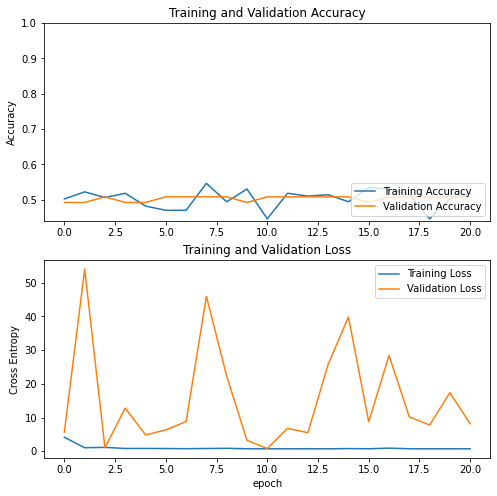

without early stopping


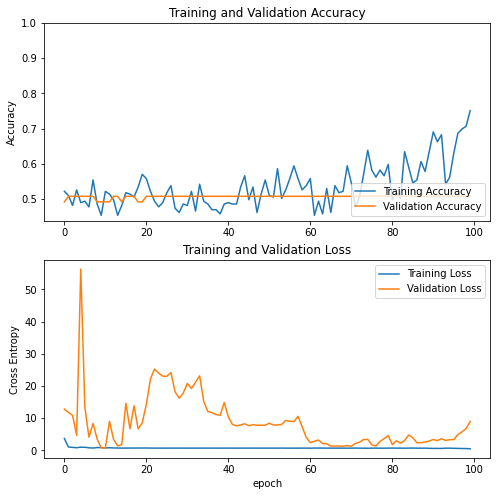

In [35]:
print("with early stopping")
plot_history(load_history('early_aug_pretrained_mobilenet'))
print("without early stopping")
plot_history(load_history('aug_pretrained_mobilenet'))

## Conclusion
- According to the experimental results, the models seem to be overfitting when they are trained without stopping criteria (early stopping).
- In the consideration on validation accuracies, the performance results are poor.
- Althouhg we add augmentation, it is still not better.